# Workflow Debugging

In [ ]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    folder_path="qasm_files/"  # , compiled_path="qasm_compiled_postprocessed/"
)

In [ ]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data = np.load("training_data.npy", allow_pickle=True)

names_list = list(np.load("names_list.npy", allow_pickle=True))

scores_list = list(np.load("scores_list.npy", allow_pickle=True))
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

Number of used and non-zero features:  26


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best GridSearch Params:  DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features=11,
                       max_leaf_nodes=82, min_samples_leaf=2)
Best Training accuracy:  0.739606719210254
Test accuracy:  0.7
Compilation paths from Train Data:  {0, 1, 2, 3, 6, 7, 8, 11, 12, 13, 15, 16, 17}
Compilation paths from Test Data:  {0, 1, 2, 3, 6, 7, 8, 11, 12, 15, 16, 17}
Compilation paths from Predictions:  {0, 1, 2, 6, 7, 11, 12, 15, 16, 17}


AttributeError: type object 'Predictor' has no attribute 'plot_eval_all_detailed_compact'

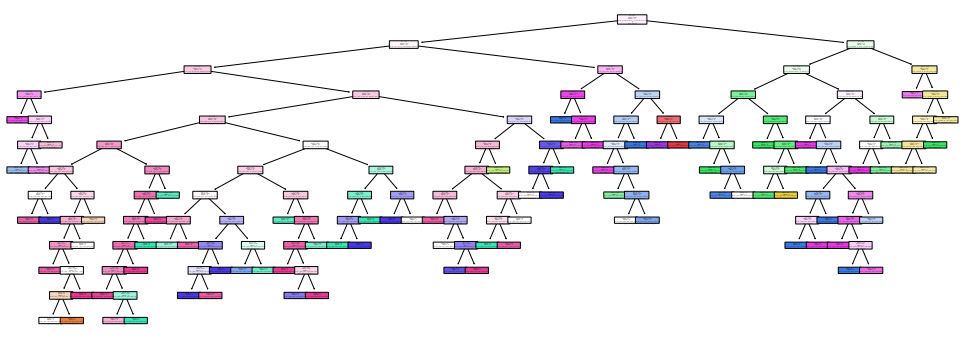

In [2]:
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

# Parameter Gridsearch

In [ ]:
import matplotlib.pyplot as plt
from predictor.src import utils
from sklearn.tree import plot_tree
from sklearn import tree

X, y = zip(*training_data)
non_zero_indices = []
X = np.array(X)
y = np.array(y)
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]
# scaler = preprocessing.StandardScaler().fit(X)
# X = preprocessing.normalize(X, norm='l2')
# X = scaler.transform(X)

X_new, y_new, indices = np.array(X), np.array(y), np.array(range(len(y)))
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X_new, y_new, indices, test_size=0.3, random_state=42)

clf_instance = tree.DecisionTreeClassifier()

In [ ]:
# DecisionTreeClassifier(criterion='entropy', max_depth=12, max_features=31,
#                       max_leaf_nodes=182, min_samples_leaf=2,
#                       min_samples_split=14)
# 0.7484197118063849

from sklearn.model_selection import GridSearchCV

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": [i for i in range(1, 15, 1)],
        "min_samples_split": [i for i in range(2, 20, 4)],
        "min_samples_leaf": [i for i in range(2, 20, 4)],
        "max_leaf_nodes": [i for i in range(2, 200, 40)],
        "max_features": [i for i in range(1, 45, 10)],
    },
]
clf = GridSearchCV(clf_instance, tree_param, cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.mean(y_pred == y_test))
print(clf.best_estimator_)
print(clf.best_score_)

# Decision Path Generation

In [ ]:
non_zero_indices = []
X = np.array(X)
y = np.array(y)
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

openqasm_qc_list = utils.get_openqasm_gates()
res = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
res.append("num_qubits")
res.append("depth")
for i in range(1, 6):
    res.append(str(i) + "_max_interactions")

X_test = X[3:4]
clf_instance = Predictor._clf.best_estimator_
n_nodes = clf_instance.tree_.node_count
children_left = clf_instance.tree_.children_left
children_right = clf_instance.tree_.children_right
feature = clf_instance.tree_.feature
threshold = clf_instance.tree_.threshold
node_indicator = clf_instance.decision_path(X_test)
leaf_id = clf_instance.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=res[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
print("Prediction: ", clf_instance.predict(X_test))

In [ ]:
print(node_indicator)

# Debugging

In [ ]:
qubit_list_sorted = (
    2,
    2,
    2,
    3,
    3,
    3,
    3,
    3,
    3,
    4,
    4,
    4,
    4,
    4,
    4,
    5,
    5,
    5,
    5,
    5,
    5,
    5,
    6,
    6,
    6,
    6,
    6,
    6,
    6,
    7,
    7,
    7,
    7,
    7,
    8,
    8,
    8,
    8,
    8,
    8,
    8,
    9,
    9,
    9,
    9,
    9,
    9,
    9,
    9,
    9,
    9,
    10,
    10,
    10,
    10,
    10,
    10,
    10,
    10,
    10,
    10,
    10,
    11,
    11,
    11,
    11,
    11,
    11,
    12,
    12,
    12,
    12,
    12,
    13,
    13,
    13,
    13,
    13,
    14,
    14,
    14,
    14,
    15,
    15,
    15,
    15,
    16,
    16,
    17,
    17,
    17,
    17,
    17,
    18,
    18,
    18,
    19,
    19,
    19,
    19,
    19,
    19,
    20,
    20,
    21,
    21,
    21,
    21,
    22,
    22,
    23,
    23,
    23,
    23,
    23,
    23,
    23,
    23,
    23,
    24,
    24,
    24,
    24,
    25,
    25,
    25,
    25,
    25,
    26,
    26,
    26,
    26,
    27,
    27,
    27,
    28,
    28,
    28,
    28,
    28,
    29,
    29,
    30,
    30,
    30,
    31,
    31,
    31,
    32,
    32,
    32,
    32,
    33,
    33,
    33,
    33,
    33,
    33,
    34,
    35,
    35,
    35,
    35,
    36,
    36,
    37,
    37,
    37,
    38,
    38,
    38,
    38,
    39,
    39,
    39,
    40,
    40,
    40,
    40,
    40,
    41,
    41,
    42,
    42,
    42,
    42,
    43,
    43,
    43,
    44,
    44,
    44,
    44,
    44,
    44,
    45,
    46,
    46,
    46,
    47,
    47,
    48,
    48,
    48,
    49,
    49,
    49,
    49,
    49,
    50,
    50,
    50,
    50,
    51,
    51,
    51,
    52,
    52,
    53,
    53,
    53,
    53,
    54,
    54,
    54,
    54,
    54,
    55,
    55,
    55,
    55,
    56,
    56,
    56,
    56,
    57,
    57,
    57,
    57,
    57,
    57,
    58,
    58,
    58,
    58,
    59,
    59,
    59,
    59,
    59,
    59,
    60,
    60,
    60,
    60,
    60,
    60,
    61,
    61,
    61,
    61,
    61,
    61,
    61,
    61,
    62,
    62,
    62,
    62,
    62,
    62,
    62,
    63,
    63,
    63,
    65,
    66,
    66,
    66,
    67,
    68,
    68,
    68,
    68,
    69,
    69,
    69,
    70,
    70,
    70,
    71,
    71,
    72,
    72,
    72,
    72,
    72,
    73,
    73,
    73,
    74,
    74,
    74,
    74,
    75,
    75,
    76,
    76,
    78,
    78,
    78,
    78,
    79,
    80,
    80,
    80,
    81,
    82,
    84,
    86,
    88,
    90,
    91,
    93,
    94,
    95,
    96,
    97,
    99,
    102,
    105,
    107,
    109,
    110,
    114,
    114,
    115,
    116,
    117,
    118,
)

In [ ]:
X.shape

In [ ]:
a = np.array((qubit_list_sorted))
print(a.flatten())
a[0]

In [ ]:
a = np.where(np.array(qubit_list_sorted) > 7)
len(a)
print(a)

# Nachbehandlung OQC qasm files

In [ ]:
import os

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if "oqc_qiskit" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            for line in lines:
                if not (
                    "gate rzx" in line.strip("\n") or "gate ecr" in line.strip("\n")
                ):
                    f.write(line)
                if "gate ecr" in line.strip("\n"):
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )

        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

    elif "oqc_tket" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            count = 0
            for line in lines:
                f.write(line)
                count += 1
                if count == 2:
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )
        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

# Nachbehandlung: Check if File is readable at all

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if f.endswith(".qasm"):
        try:
            qc = QuantumCircuit.from_qasm_file(f)
        except Exception as e:
            print("Fail: ", e)
            # Delete file: os.remove(f)

In [ ]:
import glob

files = glob.glob("qasm_compiled/ae_indep_2_*")
print(files)

In [ ]:
np.median([i for i in range(1, 20)])